In [5]:
%matplotlib inline
datadir = './data/'

import urllib.request
import os
import gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))
        
dataset = "Baby"
download_data(dataset, datadir)

Dataset Baby has already been downloaded to ./data/


In [6]:
import json

def load_data(dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
        for line in f:                            # read file line by line
            item_hash = hash(line)                # we will use this later for partitioning our data 
            item = json.loads(line)               # convert JSON string to Python dict
            item['hash'] = item_hash              # add hash for identification purposes
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

# load the data...
baby = load_data(dataset, datadir)
# ... and have a look at an example item (item number 9426):
print(baby[9426])
#for i, l in enumerate(baby):
#    if l['overall'] == 5.0 and 'horrible' in l['reviewText'] and 'bad' in l['reviewText'] and l['helpful'][0]>0:
#        print(i, l['reviewText'])

Loaded 160792 data for dataset Baby
{'reviewerID': 'A2H4QWDVXARPAU', 'asin': 'B0000TYHD2', 'reviewerName': 'Erin White "Erin"', 'helpful': [7, 8], 'reviewText': "I bought this pump for my new baby because it just as others below have said it looks more comfortable than others and it is! Including Medela. With my other child I encountered breastfeeding problems and had a horrible cheap pump. Now with my new baby she was born with a heart problem (she is fine now after a long road to recovery) and had to stay in the hospital for an extended length of time. Meanwhile I had other children at home and we live 6 hours away from our family and so I had no choice but to divide my time between the hospital and home, which meant I needed a hospital grade pump originally I rented one from the hospital (Medela) and it made my breasts hurt really bad. On the way home from the hospital I stopped in at Babiesrus and bought this pump because it was on our registry (we studied and found it to be more c

In [7]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test
    
baby_train, baby_valid, baby_test = partition_train_validation_test(baby)

print("Now we have", len(baby_train), "training examples,", len(baby_valid),
      "validation examples, and", len(baby_test), "test examples")

Now we have 96434 training examples, 32295 validation examples, and 32063 test examples


In [8]:
from nltk.corpus import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print('Some positive words:', ",".join(random.sample(positive_words, 10)))
print('Some negative words:', ",".join(random.sample(negative_words, 10)))

intersection = positive_words & negative_words
print("Words that appear in both sets: " + ",".join(intersection))



Some positive words: popular,super,embolden,loving,phenomenal,luster,attraction,supporter,pardon,eases
Some negative words: sub-par,officious,bother,unwillingness,obsessively,listless,second-tier,overpower,unreadable,despot
Words that appear in both sets: envious,enviousness,enviously


In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))
    
    
    
        

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [10]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText']))for item in data])

X_train = dataset_to_matrix(baby_train)
most_pos, most_neg = numpy.argmax(X_train, axis=0)
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos))
print(baby_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg))
print(baby_train[most_neg])




We found a fraction of 100.000000 % positive words for example 5896
{'reviewerID': 'AKU0ZZ3IEZW42', 'asin': 'B0001BUKA8', 'helpful': [0, 0], 'reviewText': 'useful peace', 'overall': 5.0, 'summary': 'Five Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': -7001574374936113780}
We found a fraction of 73.333333 % negative words for example 62808
{'reviewerID': 'A2T1CRZ12GUT8Z', 'asin': 'B00440D022', 'reviewerName': 'Oahu Computer Guy &amp; Foodie', 'helpful': [0, 0], 'reviewText': 'They work as expected, my daughter loves them.  Quack Quack Quack Quack Quack Quack Quack Quack Quack Quack, and Quack', 'overall': 5.0, 'summary': 'What can I say?', 'unixReviewTime': 1359849600, 'reviewTime': '02 3, 2013', 'hash': -4904862185447173577}


In [11]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(baby_train)

print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)


Our feature matrix is two-dimensional and has shape (96434, 2)
Our target vector is one-dimensional and has shape (96434,)


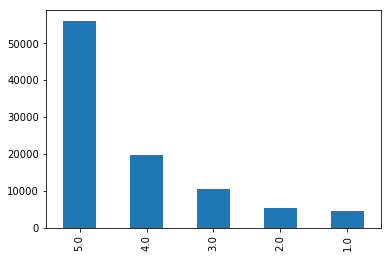

In [12]:
import pandas
pandas.Series(Y_train).value_counts().plot.bar()

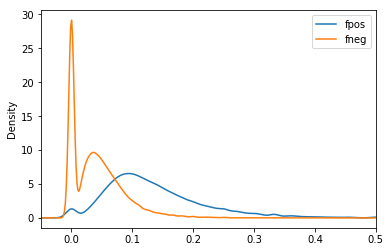

In [13]:
df = pandas.DataFrame(data = X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))

In [14]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train, Y_train)

print("The coefficient for the fpos variable is", lreg.coef_[0])
print("The coefficient for the fneg variable is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)


The coefficient for the fpos variable is 3.16811562385
The coefficient for the fneg variable is -5.75550222886
The intercept is 4.02224629871


/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [15]:
features = [[0.2, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0.2*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 4.655869 stars
This is the same as 4.655869 stars


In [16]:
features = [[0, 0.2]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0 * lreg.coef_[0] + 0.2 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)


The expected rating is 2.871146 stars
This is the same as 2.871146 stars


In [17]:
def predict_lreg(features):
    expected_rating = lreg.predict(features)
    expected_rating[expected_rating > 5.0 ] = 5.0
    expected_rating[expected_rating < 1.0 ] = 1.0
    return expected_rating

pred_train = predict_lreg(X_train)

In [18]:
def analyze_training_example(i):
    print("Training example number", i)
    print("True rating = %f stars, expected rating = %f stars" % (Y_train[i], 
                                                                  pred_train[i]))
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % baby_train[i]['reviewText'])

for i in [0, 10000, 20000, 30000, 50000]:
    analyze_training_example(i)

Training example number 0
True rating = 5.000000 stars, expected rating = 4.233454 stars
Features = 0.066667 / 0.000000
Review text = This book is such a life saver.  It has been so helpful to be able to go back to track trends, answer pediatrician questions, or communicate with each other when you are up at different times of the night with a newborn.  I think it is one of those things that everyone should be required to have before they leave the hospital.  We went through all the pages of the newborn version, then moved to the infant version, and will finish up the second infant book (third total) right as our baby turns 1.  See other things that are must haves for baby at [...]
Training example number 10000
True rating = 5.000000 stars, expected rating = 3.933062 stars
Features = 0.133333 / 0.088889
Review text = I love this blanket!  It is nice and sturdy and does not blow away in the wind.  I use it at the park, beach, and many other places.  If the ground it wet it will not soak

In [19]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(pred_train, Y_train)
print("The mean absolute error on the training data is %f stars" % mae_train)


The mean absolute error on the training data is 0.828451 stars


In [20]:
def discretize_targets(Y):
    return Y <= 3.0

D_train = discretize_targets(Y_train)
print("The training data contains %f %% dissatisfied customers" % (100.*D_train.mean()))
print(D_train[:10])

The training data contains 21.283987 % dissatisfied customers
[False False False False False False False False False False]


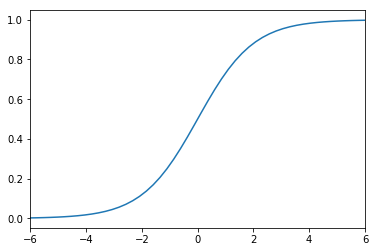

In [21]:
points = numpy.linspace(-6.0, 6.0)
logistic_function = pandas.Series(1/(numpy.exp(-points)+1), index=points)
logistic_function.plot()

In [23]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, D_train)
# The predict_proba() method produces a matrix with two columns
# the first column contains the probability for the label being "false" (satisfied customer)
# the second column contains the probability for the label being "true" (dissatisfied customer)
# the sum of both columns is 1
# we select the second column with [:,1]
# [:,0] would select the first column
# [1,:] would select the second row
prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5
max_prob2 = numpy.argmax(prob2_train)
min_prob2 = numpy.argmin(prob2_train)

def analyze_training_example_2(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % baby_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)

Training example number 28363
True rating = 1.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.996908
Features = 0.000000 / 0.666667
Review text = They leak really bad.


In [24]:
analyze_training_example_2(min_prob2)

Training example number 5896
True rating = 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000039
Features = 1.000000 / 0.000000
Review text = useful peace


In [25]:
from sklearn.metrics import precision_score, recall_score
precision2 = precision_score(D_train, pred2_train)
recall2 = recall_score(D_train, pred2_train)
print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.596729 and recall = 0.092424


Precision as function of threshold:


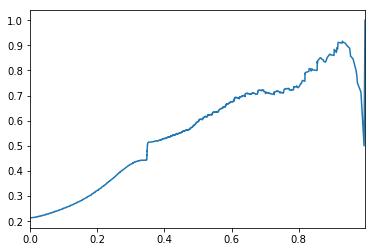

In [26]:
from sklearn.metrics import precision_recall_curve
all_precision2, all_recall2, all_thresh2 = precision_recall_curve(
    D_train, prob2_train)
print("Precision as function of threshold:")
pandas.Series(all_precision2[:-1], index=all_thresh2).plot()


Recall as function of threshold:


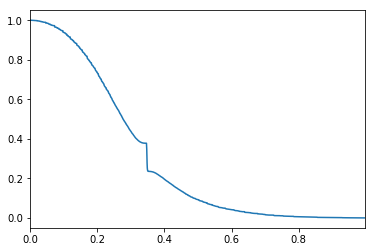

In [27]:
print("Recall as function of threshold:")
pandas.Series(all_recall2[:-1], index=all_thresh2).plot()


Now the precision is 0.483276 and the recall is 0.156979


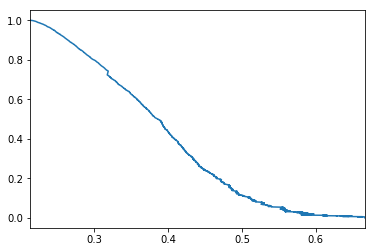

In [28]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
nb = GaussianNB().fit(X_train, D_train)
prob3_train = nb.predict_proba(X_train)[:,1]
pred3_train = prob3_train>0.5
precision3 = precision_score(D_train, pred3_train)
recall3 = recall_score(D_train, pred3_train)
print("Now the precision is %f and the recall is %f" % (precision3, recall3))
all_precision3, all_recall3, all_thresh3 = precision_recall_curve(
    D_train, prob3_train)
pandas.Series(all_recall3[:-1], index=all_precision3[:-1]).plot()

# TensorFlow

In [29]:
import tensorflow as tf
feat_cols = [tf.feature_column.numeric_column(key="fpos"),
             tf.feature_column.numeric_column(key="fneg")]
model = tf.estimator.LinearRegressor(feature_columns=feat_cols)
get_training_data = tf.estimator.inputs.numpy_input_fn(
                     x={"fpos" : X_train[:,0], "fneg" : X_train[:,1]},
                     y=Y_train, num_epochs=None, shuffle=True)

model.train(input_fn=get_training_data, steps=5000)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
eval_training_data = tf.estimator.inputs.numpy_input_fn(
                     x={"fpos":X_train[:,0], "fneg": X_train[:,1]},
                     num_epochs=1, shuffle=False)
pred_train_tf = numpy.array([item['predictions'][0] for item in 
                         model.predict(input_fn=eval_training_data)])
mae_train_tf = mean_absolute_error(pred_train_tf, Y_train)
print("The mean absolute error on the training data is %f stars" 
      % mae_train_tf)

## NLTK Built In Sentiment Analyzer

In [30]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import mark_negation
examples_negation = ["This product wasn't bad.",
                     "This is not a bad product.",
                     "This product was bad.",
                     "This is a bad product."]

for sentence in examples_negation:
    tokens_with_negation = mark_negation(word_tokenize(sentence.lower()))
    print("Sentence =", sentence)
    print(tokens_with_negation)

negated_stopwords = set(x+"_NEG" for x in eng_stopwords)
all_stopwords = eng_stopwords.union(negated_stopwords)        # set union
    
def tokenize_with_negation(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        pretokens = word_tokenize(sentence.lower())
        pretokens = [x for x in pretokens if any(i.isalpha() for i in x)]
        pretokens = mark_negation(pretokens)
        tokens.extend(x for x in pretokens if x not in all_stopwords)
    return tokens

print(baby_train[31]['reviewText'])
print(tokenize_with_negation(baby_train[31]['reviewText']))

Sentence = This product wasn't bad.
['this', 'product', 'was', "n't", 'bad_NEG', '.']
Sentence = This is not a bad product.
['this', 'is', 'not', 'a_NEG', 'bad_NEG', 'product_NEG', '.']
Sentence = This product was bad.
['this', 'product', 'was', 'bad', '.']
Sentence = This is a bad product.
['this', 'is', 'a', 'bad', 'product', '.']
Perfect way to keep track of the day for a little one-- this journal allows for detailed tracking of milk intake, diapers, sleep, and activity. Highly recommended as a perfect way to keep track and organize information in one easy to travel with place!
['perfect', 'way', 'keep', 'track', 'day', 'little', 'one', 'journal', 'allows', 'detailed', 'tracking', 'milk', 'intake', 'diapers', 'sleep', 'activity', 'highly', 'recommended', 'perfect', 'way', 'keep', 'track', 'organize', 'information', 'one', 'easy', 'travel', 'place']


In [31]:
all_positive_words = positive_words.union({x+"_NEG" for x in negative_words})
all_negative_words = negative_words.union({x+"_NEG" for x in positive_words})

def pos_neg_fraction_with_negation(text):
    tokens = tokenize_with_negation(text)
    # count how many positive and negative words occur in the text
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in all_positive_words:
            count_pos += 1
        if t in all_negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:  # avoid division by zero
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example))
print(pos_neg_fraction_with_negation(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [32]:
pos_example_neg = 'This is not a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example_neg = 'This is not a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example_neg))
print(pos_neg_fraction_with_negation(neg_example_neg))

(0.0, 0.8571428571428571)
(0.8571428571428571, 0.0)


In [41]:
def dataset_to_matrix_with_neg(data):
    return numpy.array([list(pos_neg_fraction_with_negation(item['reviewText'])) for item in data])

X_train_neg = dataset_to_matrix_with_neg(baby_train)

In [34]:
lreg_neg = LinearRegression().fit(X_train_neg, Y_train)
pred_train_neg = lreg_neg.predict(X_train_neg)
mae_train_with_neg = mean_absolute_error(pred_train_neg, Y_train)
print("Now the mean absolute error on the training data is %f stars" % mae_train_with_neg)

Now the mean absolute error on the training data is 0.810902 stars


Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor
rf_neg = RandomForestRegressor().fit(X_train_neg, Y_train)
pred_train_rf_neg = rf_neg.predict(X_train_neg)
mae_train_rf_neg = mean_absolute_error(pred_train_rf_neg, Y_train)
print("A nonlinear regressor achieves a MAE of %f stars" % mae_train_rf_neg)

A nonlinear regressor achieves a MAE of 0.709601 stars


In [36]:
print(baby_train[49000]['reviewText'])

This diaper bag has been great! It has so many different compartments for all of the different things that you need. May not seem like a necessity, but when you have so many things and you need the diaper rash cream, it is nice to know exactly where it is. I haven't had any issues at all. I have had it a year. Yes, it does wear, but most things do. The changing pad that it comes with is better than any I have seen! Definitely would recommend this.Review edit:I changed my review from 5 stars to 4 stars. This was a really wonderful diaper bag, but it did wear pretty easily. I was able to get a good 8 months or so out of it, though.


In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
text = baby_train[50000]['reviewText']
for s in sent_tokenize(text):
    print(s)
    print(sia.polarity_scores(s))

I bought these for my two boppy pillows (I am about to have twins), and this is my fourth pregnancy.
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
I went through three pregnancies without a waterproof slipcover, and wonder how I ever did it (I washed the pillow constantly, that's how!).
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
These are so much nicer b/c they are machine washable, and they protect your pillow - just put it underneath the pretty slipcover.
{'neg': 0.0, 'neu': 0.679, 'pos': 0.321, 'compound': 0.8393}
I was also extremely happy to see that the material is not plasticy or vinyl at all (I thought it would be) - it's actually material that is waterproof, much like a microfiber or some sort.
{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.7574}
Highly recommended!
{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.3367}


In [44]:
def sia_features(dataset):
    """
    For each review text in the dataset, extract:
    (1) mean positive sentiment over all sentences
    (2) mean neutral sentiment over all sentences
    (3) mean negative sentiment over all sentences 
    (4) maximum positive sentiment over all sentences
    (5) maximum neutral sentiment over all sentences
    (6) maximum negative sentiment over all sentences
    """
    feat_matrix = numpy.empty((len(dataset), 6))
    for i in range(len(dataset)):
        sentences = sent_tokenize(dataset[i]['reviewText'])
        nsent = len(sentences)
        if nsent:
            sentence_polarities = numpy.empty((nsent, 3))
            for j in range(nsent):
                polarity = sia.polarity_scores(sentences[j])
                sentence_polarities[j, 0] = polarity['pos']
                sentence_polarities[j, 1] = polarity['neu']
                sentence_polarities[j, 2] = polarity['neg']
            # mean over the columns
            feat_matrix[i, 0:3] = numpy.mean(sentence_polarities, axis = 0)
            # maximum over the columns
            feat_matrix[i, 3:6] = numpy.max(sentence_polarities, axis = 0)
        else:
            feat_matrix[i, 0:6] = 0.0
    return feat_matrix
            
sia_tr = sia_features(baby_train)
print(sia_tr[:10])
        

[[ 0.0198      0.9678      0.0124      0.099       1.          0.062     ]
 [ 0.03833333  0.84266667  0.119       0.115       1.          0.357     ]
 [ 0.12725     0.8365      0.03625     0.194       0.865       0.145     ]
 [ 0.1595      0.7775      0.063       0.319       0.874       0.126     ]
 [ 0.073       0.927       0.          0.219       1.          0.        ]
 [ 0.3115      0.6885      0.          0.571       1.          0.        ]
 [ 0.174125    0.825875    0.          0.339       1.          0.        ]
 [ 0.0307      0.9106      0.0587      0.122       1.          0.257     ]
 [ 0.1035      0.87575     0.02075     0.279       1.          0.096     ]
 [ 0.29133333  0.70866667  0.          0.406       0.787       0.        ]]


In [53]:
#note that is arange not arrange
testmat = numpy.arange(12.).reshape((3,4))
print(testmat)
print(numpy.max(testmat, axis = 0))
print(numpy.mean(testmat, axis = 1))


[[  0.   1.   2.   3.]
 [  4.   5.   6.   7.]
 [  8.   9.  10.  11.]]
[  8.   9.  10.  11.]
[ 1.5  5.5  9.5]


In [46]:
def len_features(dataset):
'''Add two features:
(1) length of review (in thousands of character) - truncate at 2,500
(2) percentage of exclamation marks(in %)'''    

len_tr = len_fearyres(baby_train)

IndentationError: expected an indented block (<ipython-input-46-5659b525d4d0>, line 4)

In [48]:
print(X_train_neg.shape, sia_tr.shape)

(96434, 2) (96434, 6)


In [51]:
# stack horizontally
X_train_augmented = numpy.concatenate((X_train_neg, sia_tr), axis = 1)
lreg_augmented = LinearRegression().fit(X_train_augmented, Y_train)
pred_train_augmented = lreg_augmented.predict(X_train_augmented)
mae_train_augmented = mean_absolute_error(pred_train_augmented, Y_train)
print("Now the mean absolute error on the training data is %f stars" %mae_train_augmented)

Now the mean absolute error on the training data is 0.754507 stars


In [52]:
# random forest
rf_augmented = RandomForestRegressor().fit(X_train_augmented, Y_train)
rfpred_train_augmented = rf_augmented.predict(X_train_augmented)
mae_train_rf_augmented = mean_absolute_error(rfpred_train_augmented, Y_train)
print("For the RF, it is %f stars" %mae_train_rf_augmented)

For the RF, it is 0.291786 stars


In [ ]:
X_valid_neg = dataset_to_matrix_with_neg(baby_valid)
sia_valid = sia_features(baby_valid)
# len_valid = 
X_valid_augmented = numpy.concatenate((X_valid_neg, sia_valid), axis = 1)
pred_valid_augmented =
pred_valid_rfaugmented =

mae_valid_augmented = 
mae_valid_rfaugmented =